Acess Datasource

In [1]:
import pybroker
from pybroker import YFinance
import numpy as np
from numba import njit
import pybroker
import talib
yfinance = YFinance()
df_in_sample = yfinance.query(['^GSPC'], start_date='3/1/2010', end_date='3/1/2024')
df_out_sample = yfinance.query(['^GSPC'], start_date='3/1/2010', end_date='3/1/2024')
df_sp = yfinance.query(['^GSPC'], start_date='3/1/2010', end_date='3/1/2024')


Loading bar data...
[*********************100%***********************]  1 of 1 completed
Loaded bar data: 0:00:00 

Loading bar data...


c:\Users\Ochimaru\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%***********************]  1 of 1 completed
Loaded bar data: 0:00:00 

Loading bar data...


c:\Users\Ochimaru\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%***********************]  1 of 1 completed
Loaded bar data: 0:00:00 



c:\Users\Ochimaru\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [2]:
rsi_14 = pybroker.indicator('rsi_14', lambda data: talib.RSI(data.close, timeperiod=14))
rsi_14(df_in_sample)

2010-03-01          NaN
2010-03-02          NaN
2010-03-03          NaN
2010-03-04          NaN
2010-03-05          NaN
                ...    
2024-02-23    68.293704
2024-02-26    65.157884
2024-02-27    65.914505
2024-02-28    64.447399
2024-02-29    66.942113
Length: 3525, dtype: float64

In [3]:
sma_14 = pybroker.indicator('sma_14', lambda data: talib.SMA(data.close, timeperiod=14))
sma_14(df_in_sample)


2010-03-01            NaN
2010-03-02            NaN
2010-03-03            NaN
2010-03-04            NaN
2010-03-05            NaN
                 ...     
2024-02-23    5004.334926
2024-02-26    5013.386335
2024-02-27    5022.239920
2024-02-28    5027.575614
2024-02-29    5034.601318
Length: 3525, dtype: float64

In [4]:
atr_100 = pybroker.indicator('atr_100', lambda data: talib.ATR(data.high,data.low,data.close, timeperiod=100))

In [5]:
from pybroker import IndicatorSet

indicator_set = IndicatorSet()
indicator_set.add(rsi_14, sma_14)
indicator_set2 = IndicatorSet()
indicator_set2.add(sma_14,atr_100)
indicator_set2(df_in_sample)

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


,symbol,date,atr_100,sma_14
0,^GSPC,2010-03-01,NaN,NaN
1,^GSPC,2010-03-02,NaN,NaN
2,^GSPC,2010-03-03,NaN,NaN
3,^GSPC,2010-03-04,NaN,NaN
4,^GSPC,2010-03-05,NaN,NaN
...,...,...,...,...
3520,^GSPC,2024-02-23,46.345753,5004.334926
3521,^GSPC,2024-02-26,46.169796,5013.386335
3522,^GSPC,2024-02-27,45.942097,5022.239920
3523,^GSPC,2024-02-28,45.680977,5027.575614


In [6]:
import pandas as pd
df_in_sample = df_in_sample.merge(indicator_set2(df_in_sample), how='left' ,on=['date','symbol'])
df_in_sample['pct_close'] =  (df_in_sample['close'] - df_in_sample['close'].shift(1)) / df_in_sample['close'].shift(1)
df_out_sample = df_out_sample.merge(indicator_set2(df_out_sample), how='left' ,on=['date','symbol'])
df_out_sample['pct_close'] =  (df_out_sample['close'] - df_out_sample['close'].shift(1)) / df_out_sample['close'].shift(1)
df_sp['pct_close%'] = ((df_sp['close'] / df_sp['close'].shift(1))-1)*100

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01



Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [7]:
def buy_sma_atr(ctx):
    # Check if there's no open long position
    if not ctx.long_pos():
        # Buy condition: Price is above the adjusted SMA level
        if ctx.indicator('sma_14')[-1] + ctx.indicator('atr_100')[-1] / 2 < ctx.close[-1]:
            # Calculate shares to buy to target 25% of available funds
            ctx.buy_shares = ctx.calc_target_shares(1)
    
    # Exit condition for the long position
    else:
        if ctx.indicator('sma_14')[-1] >= ctx.close[-1]:
        # Sell all shares bought when the condition is met
            ctx.sell_all_shares()


In [8]:
hold = len(df_sp)
def return_sp(ctx):
    if not ctx.long_pos():
        ctx.buy_shares = ctx.calc_target_shares(1)
    else:
        ctx.hold_bar = hold 
        return

BackTesting

In [9]:
import pybroker
from pybroker import Strategy, StrategyConfig, YFinance

pybroker.enable_data_source_cache('my_strategy')

In [10]:
config = StrategyConfig(initial_cash=100000)

In [11]:
strategy = Strategy(YFinance(), '3/1/2010', '3/1/2024',config)
strategy_wfa = Strategy(YFinance(), '3/1/2010', '3/1/2024',config)
strategy_sp = Strategy(YFinance(), '3/1/2010', '3/1/2024',config)



In [12]:
strategy.clear_executions()
strategy.add_execution(buy_sma_atr, ['^GSPC'],indicators=[sma_14,atr_100])

In [13]:
strategy_wfa.clear_executions()
strategy_wfa.add_execution(buy_sma_atr, ['^GSPC'],indicators=[sma_14,atr_100])

In [14]:
strategy_sp.clear_executions()
strategy_sp.add_execution(return_sp, ['^GSPC'])

In [15]:
result = strategy.backtest()

Backtesting: 2010-03-01 00:00:00 to 2024-03-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01



Test split: 2010-03-01 00:00:00 to 2024-02-29 00:00:00


  0% (0 of 3525) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  6% (231 of 3525) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 13% (491 of 3525) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 21% (761 of 3525) |####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (991 of 3525) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (1211 of 3525) |######              | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (1521 of 3525) |########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (1791 of 3525) |##########          | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (1921 of 3525) |##########          | Elapsed Time: 0:00:00 ETA:   0:00:00
 59% (2101 of 3525) |###########         | Elapsed Time: 0:00:00 ETA:   0:00:00
 67% (2371 of 3525) |#############       | Elapsed Time: 0:00:00 ETA:   0:00:00
 73% (2591 of 3525) |##############      | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (2821 of 3525) |################   


Finished backtest: 0:00:05


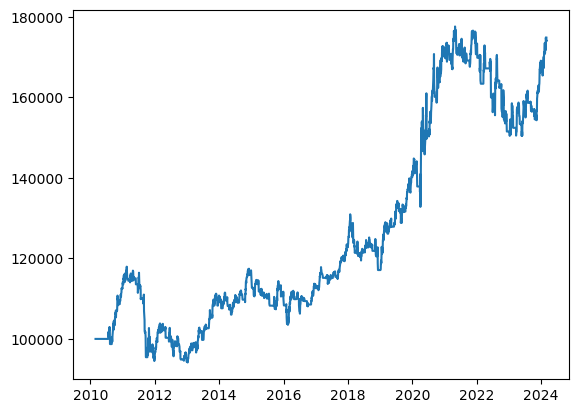

In [16]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [17]:
result.positions.head(10)

long_shares  short_shares    close     equity  \
symbol date                                                        
^GSPC  2010-07-23           91             0  1102.66  100342.06   
       2010-07-26           91             0  1115.01  101465.91   
       2010-07-27           91             0  1113.84  101359.44   
       2010-07-28           91             0  1106.13  100657.83   
       2010-07-29           91             0  1101.53  100239.23   
       2010-07-30           91             0  1101.60  100245.60   
       2010-08-02           91             0  1125.86  102453.26   
       2010-08-03           91             0  1120.46  101961.86   
       2010-08-04           91             0  1127.24  102578.84   
       2010-08-05           91             0  1125.81  102448.72   

                   market_value  margin  unrealized_pnl  
symbol date                                              
^GSPC  2010-07-23     100342.06     0.0          624.26  
       2010-07-26     101465.91     0.0         1748.11  
       2010-07-27     101359.44     0.0         1641.64  
       2010-07-28     100657.83     0.0          940.03  
       2010-07-29     100239.23     0.0          521.43  
       2010-07-30     100245.60     0.0          527.80  
       2010-08-02     102453.26     0.0         2735.46  
       2010-08-03     101961.86     0.0         2244.06  
       2010-08-04     102578.84     0.0         2861.04  
       2010-08-05     102448.72     0.0         2730.92

In [18]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,^GSPC,2010-07-23,2010-08-12,1095.80,1081.70,91,-1283.10,-1.29,-1283.10,14,-91.65,None,-14.10,33.44
2,long,^GSPC,2010-09-02,2010-10-05,1085.24,1151.72,90,5983.20,6.13,4700.10,22,271.96,None,-4.85,71.92
3,long,^GSPC,2010-10-06,2010-11-15,1158.59,1202.29,90,3933.00,3.77,8633.10,28,140.46,None,-7.18,68.49
4,long,^GSPC,2010-12-02,2011-01-31,1214.35,1281.84,89,6006.61,5.56,14639.71,40,150.17,None,-7.54,88.32
5,long,^GSPC,2011-02-02,2011-02-23,1305.11,1308.73,87,314.94,0.28,14954.65,14,22.50,None,-10.28,38.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,long,^GSPC,2023-10-10,2023-10-19,4362.55,4304.61,35,-2027.90,-1.33,54530.19,7,-289.70,None,-58.71,31.02
166,long,^GSPC,2023-11-03,2023-12-07,4353.93,4578.07,35,7844.90,5.15,62375.09,23,341.08,None,-19.70,245.46
167,long,^GSPC,2023-12-08,2024-01-04,4591.65,4707.15,35,4042.50,2.52,66417.59,17,237.79,None,-17.59,201.65


In [19]:
year_in_sample = pd.to_datetime(result.trades.loc[:,'entry_date']).dt.year
max_year_in_sample = max(year_in_sample)
min_year_in_sample = min(year_in_sample)


In [20]:
result.metrics_df

,name,value
0,trade_count,169.000000
1,initial_market_value,100000.000000
2,end_market_value,174808.450000
3,total_pnl,74808.110000
4,unrealized_pnl,0.340000
5,total_return_pct,74.808110
6,total_profit,246085.290000
7,total_loss,-171277.180000
8,total_fees,0.000000
9,max_drawdown,-27174.000000


In [21]:
result_wfa = strategy_wfa.walkforward(windows=5, train_size=0.2)

Backtesting: 2010-03-01 00:00:00 to 2024-03-01 00:00:00

Loaded cached bar data.

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01



Test split: 2010-11-19 00:00:00 to 2013-07-18 00:00:00


  0% (0 of 668) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 34% (231 of 668) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 61% (411 of 668) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 92% (621 of 668) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (668 of 668) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2013-07-19 00:00:00 to 2016-03-14 00:00:00


  0% (0 of 668) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 22% (151 of 668) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 52% (351 of 668) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 92% (621 of 668) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (668 of 668) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2016-03-15 00:00:00 to 2018-11-05 00:00:00


  0% (0 of 668) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 33% (221 of 668) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (421 of 668) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 94% (631 of 668) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (668 of 668) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2018-11-06 00:00:00 to 2021-07-02 00:00:00


  0% (0 of 668) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (171 of 668) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 48% (321 of 668) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 79% (531 of 668) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (668 of 668) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2021-07-06 00:00:00 to 2024-02-29 00:00:00


  0% (0 of 668) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% (271 of 668) |########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (521 of 668) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (668 of 668) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:02


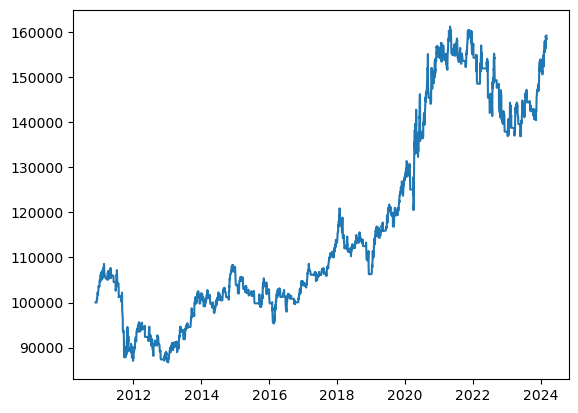

In [22]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result_wfa.portfolio.index,result_wfa.portfolio['market_value'])

In [23]:
result_wfa.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,^GSPC,2010-12-02,2011-01-31,1214.35,1281.84,82,5534.18,5.56,5534.18,40,138.35,None,-7.54,88.32
2,long,^GSPC,2011-02-02,2011-02-23,1305.11,1308.73,80,289.60,0.28,5823.78,14,20.69,None,-10.28,38.96
3,long,^GSPC,2011-03-04,2011-03-07,1321.83,1315.84,79,-473.21,-0.45,5350.57,1,-473.21,None,-9.24,9.25
4,long,^GSPC,2011-03-25,2011-04-13,1314.67,1315.27,80,48.00,0.05,5398.57,13,3.69,None,-9.41,24.79
5,long,^GSPC,2011-04-25,2011-05-06,1334.51,1344.97,78,815.88,0.78,6214.45,9,90.65,None,-5.34,36.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,long,^GSPC,2023-10-10,2023-10-19,4362.55,4304.61,32,-1854.08,-1.33,40658.74,7,-264.87,None,-58.71,31.02
163,long,^GSPC,2023-11-03,2023-12-07,4353.93,4578.07,32,7172.48,5.15,47831.22,23,311.85,None,-19.70,245.46
164,long,^GSPC,2023-12-08,2024-01-04,4591.65,4707.15,32,3696.00,2.52,51527.22,17,217.41,None,-17.59,201.65


In [24]:
result_wfa.positions.head(10)

long_shares  short_shares    close     equity  \
symbol date                                                        
^GSPC  2010-12-02           82             0  1221.53  100165.46   
       2010-12-03           82             0  1224.71  100426.22   
       2010-12-06           82             0  1223.12  100295.84   
       2010-12-07           82             0  1223.75  100347.50   
       2010-12-08           82             0  1228.28  100718.96   
       2010-12-09           82             0  1233.00  101106.00   
       2010-12-10           82             0  1240.40  101712.80   
       2010-12-13           82             0  1240.46  101717.72   
       2010-12-14           82             0  1241.59  101810.38   
       2010-12-15           82             0  1235.23  101288.86   

                   market_value  margin  unrealized_pnl  
symbol date                                              
^GSPC  2010-12-02     100165.46     0.0          588.76  
       2010-12-03     100426.22     0.0          849.52  
       2010-12-06     100295.84     0.0          719.14  
       2010-12-07     100347.50     0.0          770.80  
       2010-12-08     100718.96     0.0         1142.26  
       2010-12-09     101106.00     0.0         1529.30  
       2010-12-10     101712.80     0.0         2136.10  
       2010-12-13     101717.72     0.0         2141.02  
       2010-12-14     101810.38     0.0         2233.68  
       2010-12-15     101288.86     0.0         1712.16

In [25]:
result_wfa.metrics_df

,name,value
0,trade_count,166.000000
1,initial_market_value,100000.000000
2,end_market_value,159177.710000
3,total_pnl,59177.400000
4,unrealized_pnl,0.310000
5,total_return_pct,59.177400
6,total_profit,216198.660000
7,total_loss,-157021.260000
8,total_fees,0.000000
9,max_drawdown,-24342.980000


In [26]:
year_out_sample = pd.to_datetime(result_wfa.trades.loc[:,'entry_date']).dt.year
max_year_out_sample = max(year_out_sample)
min_year_out_sample = min(year_out_sample)

In [27]:
result_sp = strategy_sp.backtest()

Backtesting: 2010-03-01 00:00:00 to 2024-03-01 00:00:00

Loaded cached bar data.

Test split: 2010-03-01 00:00:00 to 2024-02-29 00:00:00


  0% (0 of 3525) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (141 of 3525) |                     | Elapsed Time: 0:00:00 ETA:   0:00:01
  7% (271 of 3525) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 12% (451 of 3525) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 17% (631 of 3525) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 23% (811 of 3525) |####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (991 of 3525) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00
 32% (1161 of 3525) |######              | Elapsed Time: 0:00:00 ETA:   0:00:00
 38% (1341 of 3525) |#######             | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (1521 of 3525) |########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 48% (1701 of 3525) |#########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 51% (1831 of 3525) |##########          | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (2011 of 3525) |###########        


Finished backtest: 0:00:01


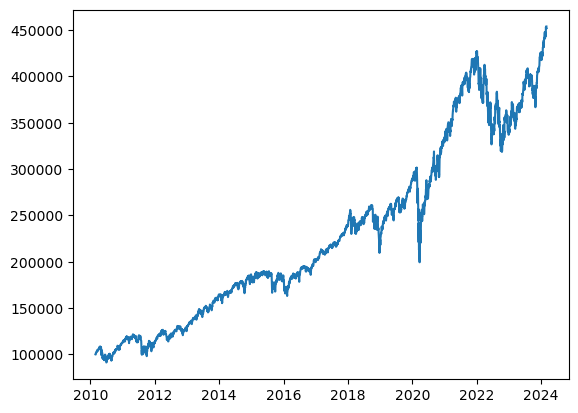

In [28]:
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result_sp.portfolio.index,result_sp.portfolio['market_value'])

In [29]:
result_sp.metrics_df

,name,value
0,trade_count,0.000000
1,initial_market_value,100000.000000
2,end_market_value,453889.810000
3,total_pnl,0.000000
4,unrealized_pnl,353889.810000
5,total_return_pct,0.000000
6,total_profit,0.000000
7,total_loss,0.000000
8,total_fees,0.000000
9,max_drawdown,-108538.180000


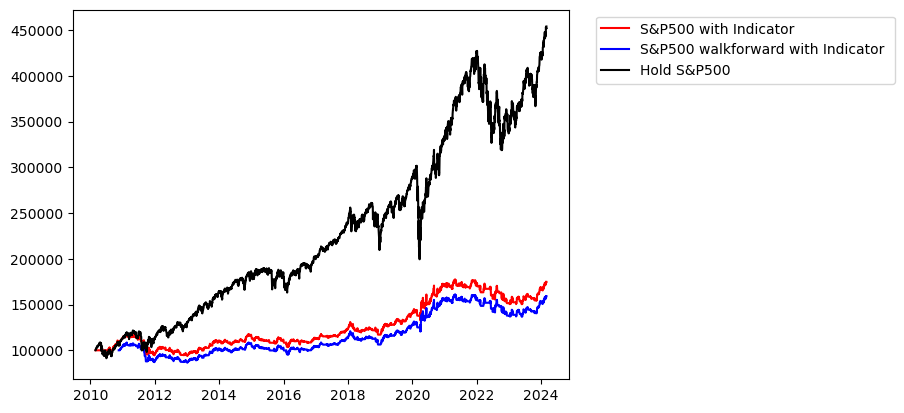

In [30]:
#compare 3 graph with in sample data , out sample data , s&p500
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index,result.portfolio['market_value'],color='r',label = 'S&P500 with Indicator')
chart.plot(result_wfa.portfolio.index,result_wfa.portfolio['market_value'],color='b',label = 'S&P500 walkforward with Indicator ')
chart.plot(result_sp.portfolio.index,result_sp.portfolio['market_value'],color='black',label = 'Hold S&P500')
plt.legend(bbox_to_anchor=(1.04,1))

In [31]:
sd_in_sample = df_in_sample['pct_close'].std()
print(f'Standard Deviation In Sample: {sd_in_sample} %')
#Assuming that there are 252 trading days
Annualized_Volatility_in_sample= sd_in_sample * np.sqrt(252)
print(f'Annualized_Volatility In Sample: {Annualized_Volatility_in_sample} %')
Annualized_Return_in_sample  =((result.metrics_df.loc[2,'value']-result.metrics_df.loc[1,'value'])/result.metrics_df.loc[1,'value'])/(max_year_in_sample-min_year_in_sample)
print(f'Annualized_Return_in_sample :{Annualized_Return_in_sample} %') 
sharpe_ratio_in_sample = Annualized_Return_in_sample/Annualized_Volatility_in_sample
print(f'Sharpe_ratio_in_sample : {sharpe_ratio_in_sample} %')
sd_out_sample = df_out_sample['pct_close'].std()
print(f'Standard Deviation Out Sample: {sd_out_sample} %')
#Assuming that there are 252 trading days
Annualized_Volatility_out_sample = sd_out_sample * np.sqrt(252)
print(f'Annualized Volatility Out Sample : {Annualized_Volatility_out_sample} %')
Annualized_Return_out_sample  =((result_wfa.metrics_df.loc[2,'value']-result_wfa.metrics_df.loc[1,'value'])/result_wfa.metrics_df.loc[1,'value'])/(max_year_out_sample-min_year_out_sample)
print(f'Annualized_Return_out_sample : {Annualized_Return_out_sample} %') 
sharpe_ratio_out_sample = Annualized_Return_out_sample/Annualized_Volatility_out_sample
print(f'Sharpe_ratio_out_sample : {sharpe_ratio_out_sample} %')

Standard Deviation In Sample: 0.011002992926361525 %
Annualized_Volatility In Sample: 0.17466709776333253 %
Annualized_Return_in_sample :0.05343460714285715 %
Sharpe_ratio_in_sample : 0.3059225682862097 %
Standard Deviation Out Sample: 0.011002992926361525 %
Annualized Volatility Out Sample : 0.17466709776333253 %
Annualized_Return_out_sample : 0.04226979285714285 %
Sharpe_ratio_out_sample : 0.24200203357370065 %
